# Using PauliPropagation.jl from Python

This notebook shows how to use the Julia package `PauliPropagation.jl` from Python. If you're more comfortable with Python but want to use this Julia package for quantum simulations, this approach works pretty well, but you will still have to learn how our functions and types work.

**Important Note:** The main purpose of this notebook is not to get you aquainted with our library. For that, please check out the notebook `1-basic-example`. It should be possible for you to read only knowing Python. Then come back and learn here how to use the library through Python. 

## What is JuliaCall?

JuliaCall is just a Python package that lets you call Julia code from Python. It is pretty handy because:

- You can use Julia's fast code without leaving Python
- You can call Julia functions almost like they are Python functions
- It handles converting data between the languages for you (often automatically!)

This is great because you can keep working in Python but still use the special features of PauliPropagation.jl when you need them.

For more information on `juliacall`, check out [this page](https://juliapy.github.io/PythonCall.jl/stable/juliacall/).

## Setting Up

First we need to load juliacall and set up the connection to Julia.

When running this for the first time, it might take a while as Julia gets set up.

In [ ]:
# Install juliacall if you haven't already
# Uncomment and run this cell if you need to install the package
# This installs into the global Python environment.
#!pip install juliacall

# We'll also need numpy and matplotlib for our Python data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt

## A Note on `juliacall` Installation and Environments

**About Jupyter kernels:** When you `pip install juliacall`, it will be installed into your global Python environment, not necessarily the environment that your Jupyter kernel is running in. If you want to use juliacall in an existing Jupyter kernel, just install the juliacall package into that kernel's Python environment with `pip install juliacall` as you usually would inside your environment. There's no need to create a separate kernel - juliacall will use the Julia instance it manages from your current Python process.

`juliacall` then manages its own Julia environment. By default, it will install a suitable version of Julia if one is not found, or you can configure it to use an existing Julia installation. Julia packages required by `juliacall` or by the Julia code you run (like `PauliPropagation.jl` here) are typically installed within this `juliacall`-managed Julia environment.

So, while `juliacall` (the Python package) lives in your Python kernel's environment, the Julia operations themselves run in a separate Julia process and environment orchestrated by `juliacall`.

## Setting Up the Python-Julia Bridge

To use Julia from Python, we first need to import and initialize the `juliacall` library. This will:

1. Start a Julia process in the background
2. Give us access to Julia's functionality through the `Main` object
3. Allow us to execute Julia code directly from Python

When using `juliacall` for the first time on a system, it might take a few minutes to set up the Julia environment.

In [ ]:
# This part can be annoying the first time - be patient!
from juliacall import Main as jl

print("Julia version:", jl.VERSION)

Now we install `Paulipropagation.jl` using the `jl.seval` functionality that evaluates strings as Julia code.

In [3]:
print("Installing PauliPropagation.jl (grab a coffee, this could take a minute)...")
jl.seval("""
    using Pkg
    if !haskey(Pkg.project().dependencies, "PauliPropagation")
        Pkg.add("PauliPropagation")
    end
""")

jl.seval("using PauliPropagation")
print("Finally! PauliPropagation.jl is loaded")

Installing PauliPropagation.jl (grab a coffee, this could take a minute)...
Finally! PauliPropagation.jl is loaded


## Using Julia Through Python

One of the great things about `juliacall` is that it handles many data conversions automatically, making Julia functions feel quite Pythonic out of the box.

For example:
- Python lists of tuples can often be passed directly where Julia expects a vector of tuples (e.g., for topologies).
- NumPy arrays are automatically converted to Julia arrays when passed to Julia functions.
- Julia numbers (like `Int` or `Float64`) are usually converted to Python `int` or `float` automatically upon return.
- Python's built-in functions like `len()` may be directly translated to, in this case, `length()` in Julia.

We can still create a few shorter alias for `PauliPropagation` for convenience.

In [4]:
pp = jl.PauliPropagation

Xsym = jl.Symbol("X")  # For X Pauli
Ysym = jl.Symbol("Y")  # For Y Pauli
Zsym = jl.Symbol("Z")  # For Z Pauli

## Understanding Pauli Strings and Operators

Let's go over some of the core concepts from PauliPropagation.jl that we will be using here, and that are also subject of our other tutorials.

The main data types we will work with are `PauliString` and `PauliSum`. A `PauliString` is a tensor product of Pauli operators $X$, $Y$, $Z$, and $I$ with a coefficient, like:

$0.5 \cdot X_1 \otimes Y_2 \otimes Z_3 \otimes I_4 \otimes ... \otimes I_{10}$

When you have multiple Pauli strings added together, that is a Pauli Sum:

$0.5 \cdot X_1 \otimes Z_2 + 1.2 \cdot Y_3 \otimes Y_4 + 0.7 \cdot Z_1 \otimes Z_5$

The quantum circuit is a sequence of gates acting onto the individual Pauli strings, and the topology of the circuit defines which qubits can interact with each other (this matters for two-qubit gates).

Let's create a simple Pauli operator and see what we get:

In [5]:
# Let's create a 10-qubit system for our examples
nqubits = 10

# A PauliString representing Z on the 5th qubit (indices are 1-based in Julia!)
observable = pp.PauliString(nqubits, Zsym, 5)
print("Single Z observable:", observable)

# We can also create more complex observables
# Format: PauliString(nqubits, [symbols ...], [positions ...], coefficient)
complex_obs = pp.PauliString(nqubits, [Xsym, Ysym, Zsym], [1, 3, 7], 2.5)
print("Complex observable:", complex_obs)

# An example of an easy PauliSum  constructor, but all the others also work 
pauli_sum_observable = pp.PauliSum(observable)

# The objects have an internal juliacall type
print("Type of pauli_sum_observable:", type(pauli_sum_observable))
# but we can call python functions on them if they are defined
print(f"Length of pauli_sum_observable: {len(pauli_sum_observable)}")

Single Z observable: PauliString(nqubits: 10, 1.0 * IIIIZIIIII)
Complex observable: PauliString(nqubits: 10, 2.5 * XIYIIIZIII)
Type of pauli_sum_observable: <class 'juliacall.AnyValue'>
Length of pauli_sum_observable: 1


## Working with Data Between Python and Julia.

A key aspect of using `juliacall` is understanding how data converts between Python and Julia. The good news is `juliacall` handles a lot of this automatically!

1.  **Julia arrays to NumPy arrays**: When a Julia function returns an array, `juliacall` often gives you an object that behaves like a NumPy array (or can be easily converted with `np.array()`).
2.  **NumPy arrays to Julia arrays**: As we've seen, passing a NumPy array to a Julia function that expects an array usually just works.
3.  **Working with Julia objects in Python**: You get back Python-side representations of Julia objects. For many common types (numbers, strings, collections), these behave very intuitively. For example, `len()` works on Julia collections.
4.  **Accessing Julia documentation from Python**: You can still use `jl.seval("@doc ...")`.

In [6]:
# Julia function returning an array
julia_random_array = jl.rand(5)
print("Julia array (via juliacall):", julia_random_array)
print("Type of Julia array object in Python:", type(julia_random_array))

# Converting to NumPy array
numpy_array_from_julia = np.array(julia_random_array)
print("NumPy array type:", type(numpy_array_from_julia))
print("NumPy array content:", numpy_array_from_julia)

# Creating a NumPy array and passing it to a Julia function that uses it
jl.seval("""
function sum_julia_array(arr)
    return sum(arr)
end
""")
my_numpy_array = np.array([1.0, 2.0, 3.0, 4.0])
sum_from_julia = jl.sum_julia_array(my_numpy_array) 
print(f"Sum from Julia (passing NumPy array {my_numpy_array}): {sum_from_julia} (type: {type(sum_from_julia)})")

# Accessing documentation
help_text = jl.seval("@doc PauliPropagation.propagate")
print("\nDocumentation for propagate function (first 10 lines):\n")
help_text_str = str(jl.string(help_text))
print("\n".join(help_text_str.split("\n")[:10]) + "\n...")

Julia array (via juliacall): [0.036662017447664064, 0.2971423897655302, 0.16795322540590507, 0.8943404674197706, 0.7977159002482177]
Type of Julia array object in Python: <class 'juliacall.VectorValue'>
NumPy array type: <class 'numpy.ndarray'>
NumPy array content: [0.03666202 0.29714239 0.16795323 0.89434047 0.7977159 ]
Sum from Julia (passing NumPy array [1. 2. 3. 4.]): 10.0 (type: <class 'float'>)

Documentation for propagate function (first 10 lines):

Base.Docs.DocStr(svec("    propagate(circ, pstr::PauliString, thetas=nothing; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, kwargs...)\n\nPropagate a `PauliString` through the circuit `circ` in the Heisenberg picture. \nThis means that the circuit is applied to the Pauli string in reverse order, and the action of each gate is its conjugate action.\nParameters for the parametrized gates in `circ` are given by `thetas`, and need to be passed as if the circuit was applied as written in the Sch

## Basic Example: Propagating an Observable Through a Quantum Circuit

Now let's see `PauliPropagation.jl` and `juliacall` in action by running a quantum circuit and seeing what happens to a propagated Pauli observable.

PauliPropagation.jl computes the evolution of observables like a Z measurement on a specific qubit under the action of a quantum circuit. Let us try a prototypical example.

Let's define an observable:

In [7]:
# We'll use the 10-qubit system defined earlier
print(f"System size: {nqubits} qubits")

# Our observable is Z on the middle qubit, as a PauliString
pstr = pp.PauliString(nqubits, Zsym, nqubits // 2)
pstr

System size: 10 qubits


PauliString(nqubits: 10, 1.0 * IIIIZIIIII)

Now we define a custom topology, where "topology" is a fancy word for "which qubits can talk to each other", and thus very important for real quantum hardware where not every qubit connects to every other one.

In PauliPropagation.jl, topologies would be defined as arrays of tuples of ints like `[(1, 2), (2, 3), ...]`. Interestingly, this is also the Python syntax and `juliacall` is smart enough to convert Python lists of tuples directly into the format Julia expects for topologies! This means topologies can be defined using pure Python syntax.

Let's create a simple ring of qubits with a few extra long-range connections:

In [ ]:
# Each tuple represents a connection between two qubits (1-indexed)
topology = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1),  # Ring
                         (1, 6), (3, 8), (5, 10)]  # Some long-range connections

# Juliacall will convert this Python list of tuples automatically when passed to a Julia function
# that expects a topology. For example, when creating a circuit:
# circuit = pp.tiltedtfitrottercircuit(nqubits, nlayers, topology=topology)

# For comparison, let's also create a standard brick layer topology using PauliPropagation.jl
# We can pass the Python list directly here too if the function supports it,
# or use Julia's own construction if needed.
# Here, bricklayertopology itself is a Julia function.
brick_topology_jl = pp.bricklayertopology(nqubits, periodic=True)

And plot it up:

Type of the Python topology:  <class 'list'>
Type of the Julia topology: <class 'juliacall.VectorValue'>


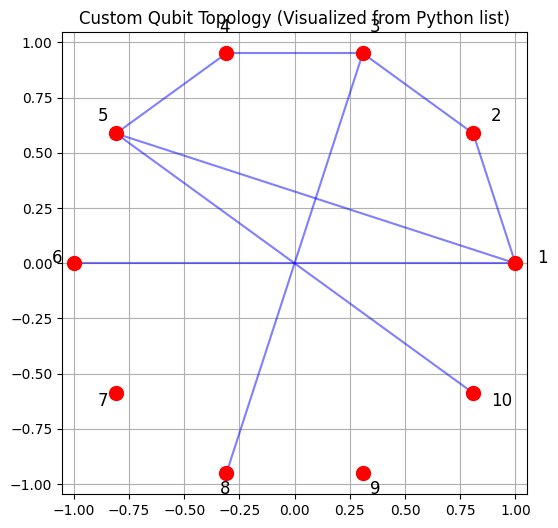

Defined custom topology in Python with 8 connections.
For comparison, the standard brick layer topology (a Julia object) has 10 connections.


In [ ]:
print("Type of the Python topology: ", type(topology))
print("Type of the Julia topology:", type(brick_topology_jl))

plt.figure(figsize=(6, 6))
plt.title("Custom Qubit Topology (Visualized from Python list)")

angles = np.linspace(0, 2*np.pi, nqubits, endpoint=False)
positions = {i+1: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}

for q1, q2 in topology:
    x1, y1 = positions[q1]
    x2, y2 = positions[q2]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.5)

for i, (x, y) in positions.items():
    plt.plot(x, y, 'ro', markersize=10)
    plt.text(x*1.1, y*1.1, f"{i}", fontsize=12)

plt.axis('equal')
plt.grid(True)
plt.show()

print(f"Defined custom topology in Python with {len(topology)} connections.")
# We can use Python's len() on Julia collections returned by juliacall!
print(f"For comparison, the standard brick layer topology (a Julia object) has {len(brick_topology_jl)} connections.")

## Understanding Propagation: 

What actually happens when calling `pp.propagate()`? The key idea is that we work in the Pauli basis and compute the action of gates on Pauli operators (also called Pauli strings). We also work in the Heisenberg picture, where we compute how measurements or observables evolve, rather than evolving quantum states, which usually require exponentially many Pauli strings to represent them.

Here some key aspects to keep in mind:

1. **Heisenberg evolution:** Instead of simulating the evolution of the quantum state, the propagation tracks how the observable operator changes as it acted on by the (inverse of the) circuit.

2. **Pauli algebra:** Each gate in the circuit transforms Pauli operators according to well-defined algebraic rules, which can be efficiently implemented.

3. **Growth of terms:** As the observable is propagated through more circuit layers, it typically expands into a sum of many Pauli terms. This can quickly become computationally intensive.

4. **Truncation for efficiency:** To keep the calculation tractable, less important terms are discarded. This is controlled by two main parameters:
   - **Coefficient truncation:** Discards terms whose coefficients fall below a threshold (`min_abs_coeff`).
   - **Weight truncation:** Limits the number of non-identity Paulis in a Pauli string (`max_weight`).
   

Balancing these truncation parameters is crucial: too aggressive, and important contributions may be lost; too loose, and the computation may become infeasible due to the rapid growth in the number of terms.

Now let us run our first simulation: The evolution under the tilted field Ising model.

In [ ]:
# Creating a Tilted Transverse Field Ising Model (TFIM) circuit with 5 layers
nlayers = 5
# Pass the Python list of tuples directly for the topology
circuit = pp.tiltedtfitrottercircuit(nqubits, nlayers, topology=topology)

# pp.countparameters(circuit) returns a Python int directly
num_parameters = pp.countparameters(circuit)
print(f"Circuit has {num_parameters} parameters.")

# Creating circuit parameters using NumPy
dt = 0.1
parameters = np.ones(num_parameters) * dt * 2  # the x2 factor is by convention in Trotter circuits
print(f"Created parameters using NumPy:")
parameters

Circuit has 140 parameters.
Created parameters using NumPy:


array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

Now define our truncation parameters and propagate!

In [ ]:
# The truncation parameters
max_weight = 6
min_abs_coeff = 1e-4

# The result, pauli_sum_result, will be a Julia object (PauliSum)
psum = pp.propagate(
    circuit, pstr, parameters, 
    max_weight=max_weight, min_abs_coeff=min_abs_coeff
)

print(f"Result has {len(psum)} Pauli terms")

# pp.overlapwithzero returns a Python float directly
overlap = pp.overlapwithzero(psum)
print(f"Expectation value: {overlap}")

Result has 1132 Pauli terms
Expectation value: 0.8628346139479492


## Simulating Quantum Dynamics

Now we will demonstrate a more sophisticated and efficient approach to quantum simulation: layer-wise evolution.

Instead of creating a circuit with multiple layers and propagating through it all at once, we create a single-layer circuit, repeatedly propagate our observable (PauliSum) through this single layer, and track the expectation value and term count after each layer.

This approach is great when we want to track how expectation values during evolution while applying any layer only once.

In [ ]:
max_layers = 20
dt = 0.1

circuit_layer = pp.tiltedtfitrottercircuit(nqubits, 1, topology=topology)
nparams = pp.countparameters(circuit_layer)
thetas = np.ones(nparams) * dt * 2


# we create the Pauli sum and then manipulate it
psum = pp.PauliSum(pp.PauliString(nqubits, Zsym, nqubits // 2))


expectations = [pp.overlapwithzero(psum)]
term_counts = [len(psum)]
print(f"Layer 0, Overlap: {expectations[0]:.4f}, Terms: {term_counts[0]}")

# this all happens in an outer Python loop
# looping in Python is not evil when it is a few slow-ish iterations
for layer in range(1, max_layers + 1):
    psum = pp.propagate(
        circuit_layer, psum, thetas,
        max_weight=max_weight, min_abs_coeff=min_abs_coeff
    )

    current_overlap = pp.overlapwithzero(psum)
    current_terms = len(psum)
    expectations.append(current_overlap)
    term_counts.append(current_terms)

    if layer % 5 == 0 or layer == 1 or layer == max_layers:
        print(f"Layer {layer}, Overlap: {current_overlap:.4f}, Terms: {current_terms}")


Layer 0, Overlap: 1.0000, Terms: 1
Layer 1, Overlap: 0.9801, Terms: 17
Layer 5, Overlap: 0.8628, Terms: 1132
Layer 10, Overlap: 0.9099, Terms: 10784
Layer 15, Overlap: 0.9459, Terms: 24672
Layer 20, Overlap: 0.8979, Terms: 35603


And now plot up the dynamics:

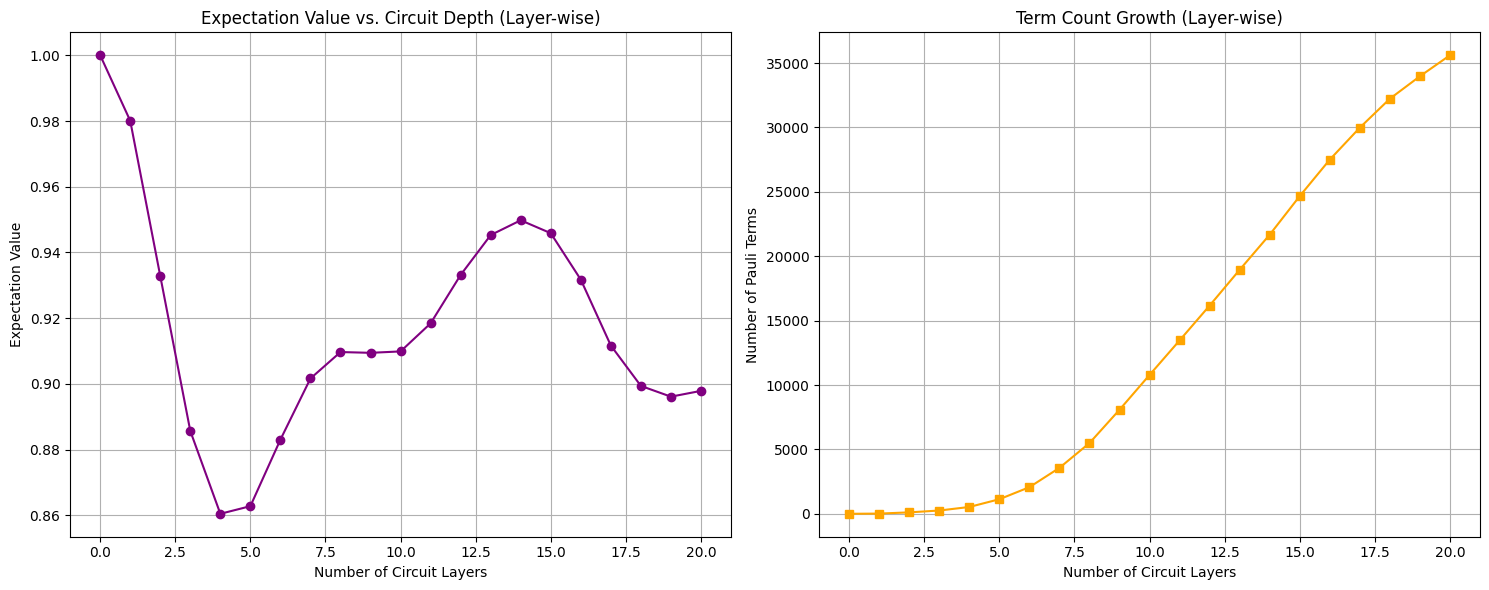

In [13]:
layer_indices = list(range(0, max_layers + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(layer_indices, expectations, 'o-', color='purple')
ax1.set_xlabel('Number of Circuit Layers')
ax1.set_ylabel('Expectation Value')
ax1.set_title('Expectation Value vs. Circuit Depth')
ax1.grid(True)

ax2.plot(layer_indices, term_counts, 's-', color='orange')
ax2.set_xlabel('Number of Circuit Layers')
ax2.set_ylabel('Number of Pauli Terms')
ax2.set_title('Term Count Growth')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Comparing Truncation Effects

One of the most important considerations when using Pauli propagation is choosing appropriate truncation parameters. Let's systematically compare different truncation settings for the layer-wise evolution and visualize their effects.

We'll compare:
- Different `max_weight` settings (2, 4, 6, 8)
- Same `min_abs_coeff` setting (1e-4)

This will help us understand the trade-off between accuracy and computational cost during the step-by-step evolution.

Max weight 2: 94 Pauli terms after 20 layers
Max weight 4: 5548 Pauli terms after 20 layers
Max weight 6: 35603 Pauli terms after 20 layers
Max weight 8: 61813 Pauli terms after 20 layers


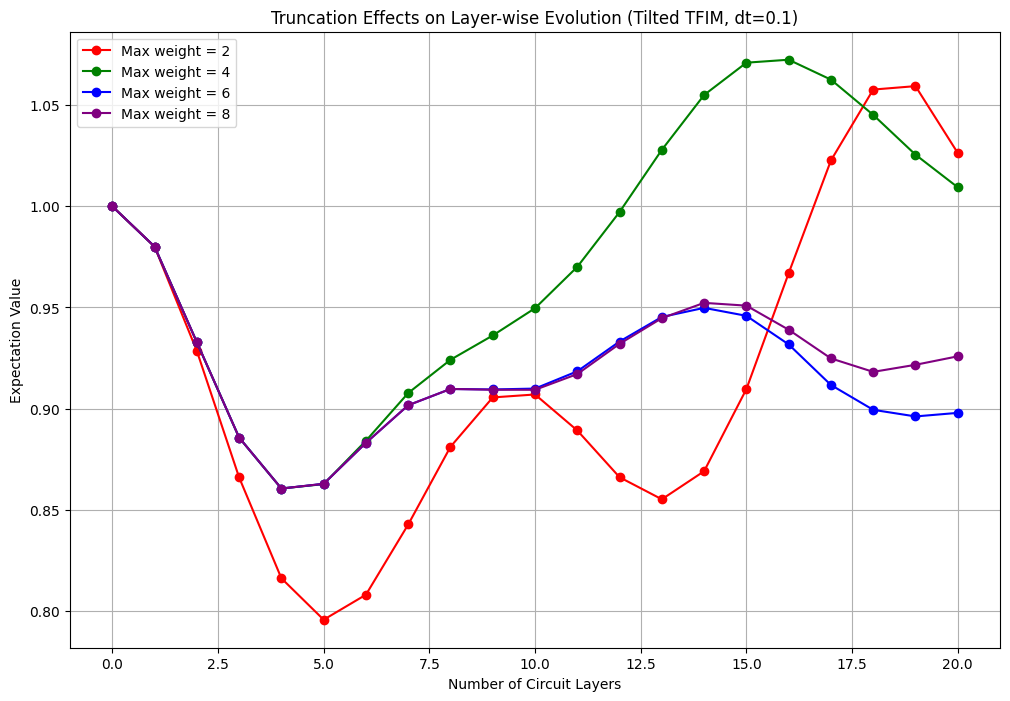

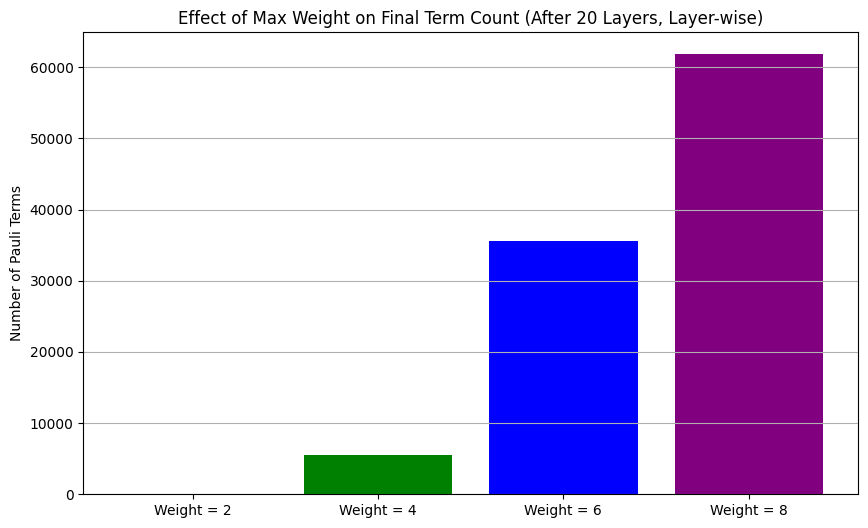

In [ ]:
weights = [2, 4, 6, 8]
colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 8))

final_term_counts = []

initial_pauli_string = pp.PauliString(nqubits, Zsym, nqubits // 2)

for idx, weight in enumerate(weights):
    psum = pp.PauliSum(initial_pauli_string)

    expectations = [pp.overlapwithzero(psum)]
    for layer in range(1, max_layers + 1):
        psum = pp.propagate(
            circuit_layer, psum, thetas,
            max_weight=weight,
            min_abs_coeff=min_abs_coeff
        )
        expectations.append(pp.overlapwithzero(psum))

    term_count = len(psum)
    final_term_counts.append(term_count)
    print(f"Max weight {weight}: {term_count} Pauli terms after {max_layers} layers")

    plt.plot(layer_indices, expectations, 'o-', color=colors[idx],
             label=f'Max weight = {weight}')

plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Truncation Effects on Layer-wise Evolution (Tilted TFIM, dt={dt})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for idx, (weight, count) in enumerate(zip(weights, final_term_counts)):
    plt.bar(f"Weight = {weight}", count, color=colors[idx])
plt.ylabel('Number of Pauli Terms')
plt.title(f'Effect of Max Weight on Final Term Count (After {max_layers} Layers, Layer-wise)')
plt.grid(True, axis='y')
plt.show()

## Summary

In this notebook, we've demonstrated how to use `PauliPropagation.jl` from Python using `juliacall`.

**Should** you use Python to use `PauliPropagation.jl`? Maybe not, but you **can**. If you really don't want to touch Julia, or you want to more easily interface with your existing Python code, this could be a great step!

Some considerations on usage from Python are the following:
- There is some overhead going back and forth between Python and Julia - not huge, but noticeable when it happens a lot in-between fast operations. Crossing the barrier once for one big function call like `propagate()` is idea.
- Error messages can be confusing - they often don't clearly indicate which side (Python or Julia) had the issue.
- You still need familiarity with our Julia package, even if you are using it from Python. A Python wrapper is not actively in progress, but please feel free to contribute to one.
- Any capabilities and limitations of `PauliPropagation.jl` still apply. 